In [26]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
from scipy import random

Константы с говорящими именами:

In [8]:
epsilon = 0.00001
max_iterations = 10000

Это функция, которая будет строить график, на котором нарисовано все, что нам нужно: исходная функция, спуск, результат.

In [9]:
def draw_plot(f, x_values, xlim, function_label, method = 'Градиентный спуск'):
    plt.figure(figsize=(12, 7))
    plt.xlim(xlim)
    
    # нарисуем функцию
    x = np.linspace(*xlim)
    plt.plot(x, f(x), label = function_label)
    
    # нарисуем градиентный спуск
    plt.plot(x_values, [f(x) for x in x_values], label = 'спуск')
    
    # отметим найденный минимум
    xmin = round(x_values[-1], 3)
    plt.scatter(xmin, f(xmin), color='r', label = '$x^*$ = {}'.format(xmin))
    
    plt.xlabel('x')
    plt.ylabel('$f(x)$')
    plt.title('{}, число шагов = {}'.format(method, len(x_values)))
    plt.legend(fontsize=13)
    plt.show()

### Обычный градиентный спуск

$x_{k+1} = x_{k} − \alpha \nabla f (x_{k}))$

$\alpha$ > 0 − параметр

In [10]:
def gradient_descent(gradient, x0, alpha):
    xk = x0
    x_values = [x0]
    while np.linalg.norm(gradient(xk)) > epsilon and len(x_values) < max_iterations:
        xk = xk - alpha * gradient(xk)
        x_values.append(xk)
    return x_values

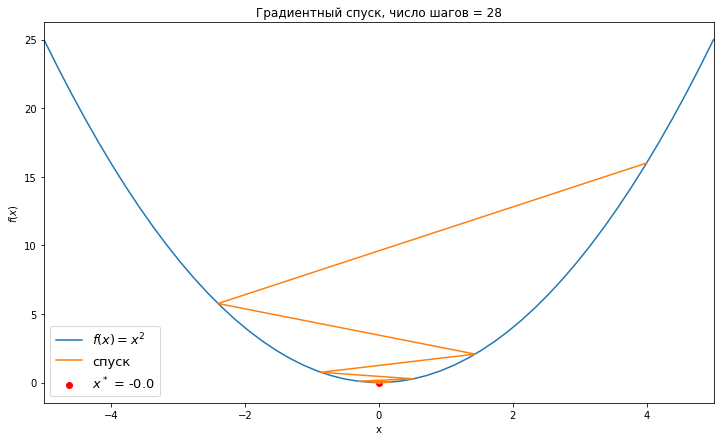

In [11]:
f = lambda x : x ** 2
df = lambda x : 2 * x

x_values = gradient_descent(df, x0 = 4, alpha = 0.8)
draw_plot(f, x_values, xlim = (-5, 5), function_label = '$f(x) = x^2$')

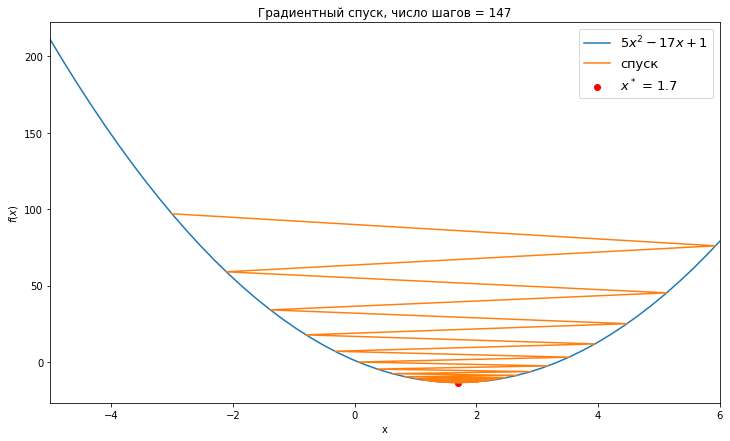

In [12]:
f = lambda x : 5 * (x ** 2) - 17 * x + 1
df = lambda x : 10 * x - 17

x_values = gradient_descent(df, x0 = -3, alpha = 0.19)
draw_plot(f, x_values, xlim = (-5, 6), function_label = '$5x^2 - 17x + 1$')

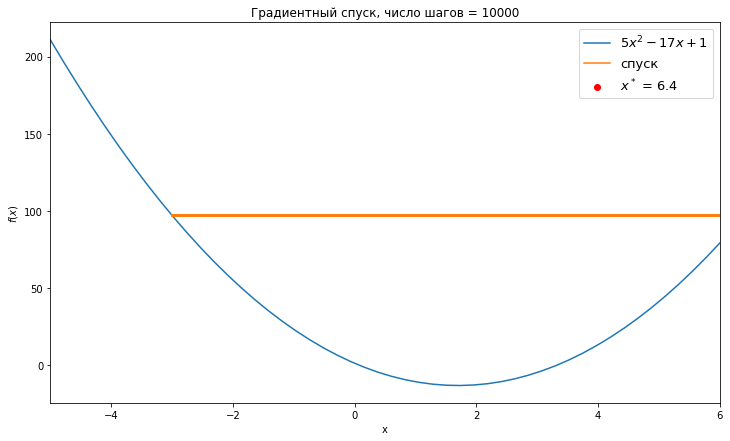

In [13]:
f = lambda x : 5 * (x ** 2) - 17 * x + 1
df = lambda x : 10 * x - 17

x_values = gradient_descent(df, x0 = -3, alpha = 0.20)
draw_plot(f, x_values, xlim = (-5, 6), function_label = '$5x^2 - 17x + 1$')

Можно заметить, что удачным подбором $\alpha$ можно сократить число шагов, а можно, наоборот, никогда не достичь нужной точки.

### Метод тяжелого шарика
$x_{k+1} = x_{k} − \alpha \nabla f (x_{k}) + \beta (x_{k} − x_{k−1})$

$\alpha > 0, \beta \geq 0$  − параметры

In [14]:
def heavy_ball(gradient, x0, alpha, beta):
    cur, prev = x0, x0
    x_values = [cur]
    while np.linalg.norm(gradient(cur)) > epsilon and len(x_values) < max_iterations:
        new = cur - alpha * gradient(cur) + beta * (cur - prev)
        prev, cur = cur, new
        x_values.append(cur)
    return x_values

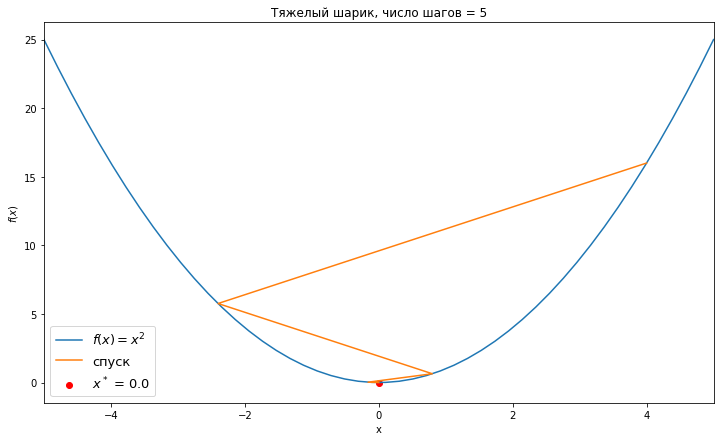

In [15]:
f = lambda x : x ** 2
df = lambda x : 2 * x

x_values = heavy_ball(df, x0 = 4, alpha = 0.8, beta = 0.1)
draw_plot(f, x_values, xlim = (-5, 5), function_label = '$f(x) = x^2$', method = 'Тяжелый шарик')

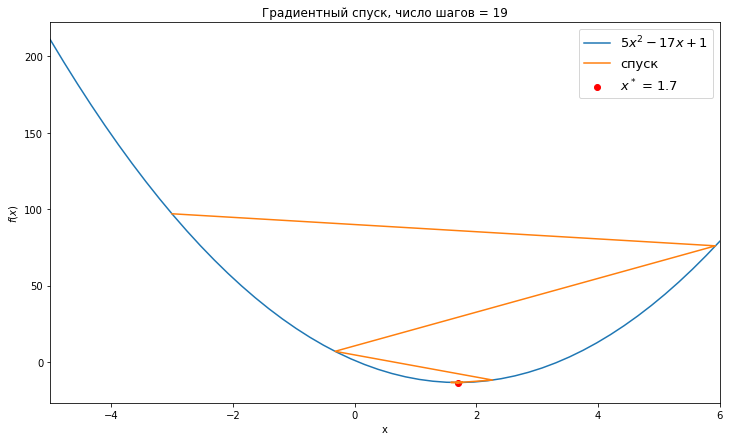

In [16]:
f = lambda x : 5 * (x ** 2) - 17 * x + 1
df = lambda x : 10 * x - 17

x_values = heavy_ball(df, x0 = -3, alpha = 0.19, beta = 0.2)
draw_plot(f, x_values, xlim = (-5, 6), function_label = '$5x^2 - 17x + 1$')

Можно заметить, что шарик скатывается быстрей, чем обычный градиентный спуск, если удачно подобрать второй коэффициент.

### Сопряженные градиенты
Рассмотрим задачу, как в 8 лекции: найти минимум $f(x) = \frac{1}{2}x^{\top}Ax - b^{\top}x$, где $A \in S_{++}$

Используем код с той же самой лекции.

In [17]:
def conjugate_gradient_quadratic(x0, A, b, eps = epsilon):
    r = A.dot(x0) - b
    p = -r
    x = x0
    iteration = 0
    while np.linalg.norm(r) > eps and iteration < max_iterations:
        alpha = -r.dot(p) / p.dot(A.dot(p))
        x = x + alpha * p
        r = A.dot(x) - b
        beta = r.dot(A.dot(p)) / p.dot(A.dot(p))
        p = -r + beta * p
        iteration += 1
    return x, iteration

Для эксперимента (для получения задачи) создадим произвольную положительно определенную матрицу A и вектор b.
Найдем минимум методом сопряженных градиентов и сравним его с минимумом, который считает встроенная функция.

In [18]:
def get_positive_matrix(n = 10):
    A = random.rand(n, n)
    return np.dot(A, A.transpose())

In [23]:
def experiment(n = 10, precision = 5):
    n = 10 
    A = get_positive_matrix(n = 10)
    b = random.rand(n)
    x0 = random.rand(n)

    xmin, iterations = conjugate_gradient_quadratic(x0, A, b)

    f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
    gradient = lambda x: A.dot(x) - b
    true_xmin = scipy.optimize.minimize(fun = f, x0 = x0, jac = gradient)['x']
    error = f(xmin) - f(true_xmin)
    return error, iterations

In [27]:
def estimate_error_and_iterations(N = 100):
    max_error = 0
    avg_iterations = 0
    for i in range(N):
        error, iterations = experiment()
        avg_iterations += iterations
        max_error = max(error, max_error)
    avg_iterations /= N
    print('максимальная ошибка: ', error)
    print('итераций в среднем: ', avg_iterations)

In [28]:
estimate_error_and_iterations()

максимальная ошибка:  3.23525455314666e-08
итераций в среднем:  11.01


### Метод Нестерова

Опять рассмотрим задачу нахождения минимума $f(x) = \frac{1}{2}x^{\top}Ax - b^{\top}x$, где $A \in S_{++}$

$\{x_k\}, \{y_k\}$ - строим две последовательности

$x_{k+1} = y_k - \frac{1}{L}\nabla f(x_k)$

$y_{k+1} = x_{k+1} + \frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}(x_{k+1}-x_k)$

Воспользуемся тем, что для такой функции $A = \nabla ^2 f$, и что $\lambda_{max}(\nabla ^2 f) \leq L$ для нахождения L. ($\lambda_{max}$ - наибольшее из собственных значений матрицы)

$\mu$ - число обусловленности, попробуем взять его равным $\frac{L}{10000}, \frac{L}{100},\frac{L}{2}$

In [29]:
def nesterov(gradient, x0, mu, L):
    xk, yk = x0, x0
    iteration = 0
    while np.linalg.norm(gradient(xk)) > epsilon and iteration < max_iterations:
        xnew = yk - 1 / L * gradient(xk)
        ynew = xnew + (L ** 0.5 - mu ** 0.5) / (L ** 0.5 + mu ** 0.5) * (xnew - xk)
        xk = xnew
        yk = ynew
        iteration += 1
    return xk, iteration

In [30]:
def get_positive_matrix(n = 10):
    A = random.rand(n, n)
    return np.dot(A, A.transpose())

In [31]:
def experiment(n = 10, precision = 5, count_mu = lambda L: L / 10000):
    n = 10 
    A = get_positive_matrix(n = 10)
    b = random.rand(n)
    x0 = random.rand(n)
    L = np.max(np.linalg.eigvalsh(A))
    mu = count_mu(L)
    
    f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
    gradient = lambda x: A.dot(x) - b
    
    xmin, iteration = nesterov(gradient, x0, mu, L)
    
    true_xmin = scipy.optimize.minimize(fun = f, x0 = x0, jac = gradient)['x']
    error = np.linalg.norm(f(xmin) - f(true_xmin))
    return error, iteration

In [32]:
def estimate_error_and_iterations(N = 100, count_mu = lambda L: L / 10000):
    max_error = 0
    avg_iterations = 0
    for i in range(N):
        error, iterations = experiment()
        avg_iterations += iterations
        max_error = max(error, max_error)
    avg_iterations /= N
    print('максимальная ошибка: ', error)
    print('итераций в среднем: ', avg_iterations)

Проведем эксперимент для $\mu = \frac{L}{10000}$:

In [33]:
estimate_error_and_iterations(count_mu = lambda L: L / 10000)

максимальная ошибка:  1.581059120780992e-05
итераций в среднем:  3661.01


Эксперимент для $\mu = \frac{L}{100}$:

In [34]:
estimate_error_and_iterations(count_mu = lambda L: L / 100)

максимальная ошибка:  2.4742674575861656e-10
итераций в среднем:  3846.14


Эксперимент для $\mu = \frac{L}{2}$:

In [35]:
estimate_error_and_iterations(count_mu = lambda L: L / 2)

максимальная ошибка:  0.0003542974623940154
итераций в среднем:  3997.94


Можно сделать вывод, что приблизитиельно одинаковы количестве итераций и точность при различных $\mu$. И метод нестерова работает намного дольше, чем метод сопряженных градиентов.